In [1]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, DepthProForDepthEstimation

In [2]:
checkpoint = "apple/DepthPro-hf"
processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DepthProForDepthEstimation.from_pretrained(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Loading weights:   0%|          | 0/1407 [00:00<?, ?it/s]

DepthProForDepthEstimation(
  (depth_pro): DepthProModel(
    (encoder): DepthProEncoder(
      (patch_encoder): DepthProPatchEncoder(
        (model): Dinov2Model(
          (embeddings): Dinov2Embeddings(
            (patch_embeddings): Dinov2PatchEmbeddings(
              (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): Dinov2Encoder(
            (layer): ModuleList(
              (0-23): 24 x Dinov2Layer(
                (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
                (attention): Dinov2Attention(
                  (attention): Dinov2SelfAttention(
                    (query): Linear(in_features=1024, out_features=1024, bias=True)
                    (key): Linear(in_features=1024, out_features=1024, bias=True)
                    (value): Linear(in_features=1024, out_features=1024, bias=True)
                  )
                  (

In [3]:
source_root = Path('datasets/ambient6k/train')

origin = source_root / 'origin'
to_thermal_list = [origin] 

In [4]:
# thermal_path = Path('/ssd8/van/OmniSR/datasets/INS/depth')
thermal_path = source_root / 'depth'

with torch.inference_mode():
    
        for to_thermal_item in to_thermal_list:
            # print(to_thermal_item)
            folder_name = to_thermal_item.stem
            dst_path = thermal_path 
            # print(dst_path)

            dst_path.mkdir(parents=True,
                        exist_ok=True)
            
            bar = tqdm(list(to_thermal_item.glob('*')))

            for image_path in bar:
                # print(f'{image_path=}')
                try:
                    raw_img = cv2.imread(str(image_path))
                    depth = processor(images=raw_img, return_tensors="pt").to(device) # HxW raw depth map

                    outputs = model(**depth)

                    post_processed_output = processor.post_process_depth_estimation(
                        outputs, target_sizes=[(raw_img.shape[0], raw_img.shape[1])],
                    )
                    predicted_depth = post_processed_output[0]["predicted_depth"]
                    depth = predicted_depth * 255 / predicted_depth.max()
                    depth = depth.detach().cpu().numpy().astype(np.float32)


                    print(depth.shape)
                    np.save(f'{dst_path}/{image_path.stem}.npy', depth)

                    # gray_depth = Image.fromarray(depth)
                    # gray_depth.save(f'{dst_path}/{image_path.name}')
                except Exception as e:
                    print(e)
                    continue

  0%|          | 0/5000 [00:00<?, ?it/s]

(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)
(1920, 2560)

Normal Map

In [5]:
# root = Path('/ssd8/van/OmniSR/datasets/INS/test')

depth_root = source_root / 'depth'
normal_root = source_root / 'normal'
normal_root.mkdir(parents=True,
                  exist_ok=True)

In [ ]:
def calculate_normal_map(img_path: Path, ksize=5):
    depth = np.load(img_path).astype(np.float32)

    dx = cv2.Sobel(depth, cv2.CV_32F, 1, 0, ksize=ksize)
    dy = cv2.Sobel(depth, cv2.CV_32F, 0, 1, ksize=ksize)

    dz = np.ones_like(dx) * -1

    normals = np.stack((dx, dy, dz), axis=-1)

    norm = np.linalg.norm(normals, axis=-1, keepdims=True)

    normal_map = (normals + 1) / 2 * 255
    normal_map = normal_map.astype("uint8")

    normal_map = normal_map.transpose(2, 0, 1)  # (H, W, C) -> (C, H, W)

    return normal_map

In [7]:
bar = tqdm(list(depth_root.glob('*.npy')))

for depth_img_path in bar:
    img_name = depth_img_path.name

    normal_map = calculate_normal_map(depth_img_path)

    np.save(f'{normal_root}/{img_name}', normal_map)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
train_depth_path = source_root / 'depth'
train_normal_path = source_root / 'normal'
train_origin_path = source_root / 'origin'
train_shadow_free_path = source_root / 'shadow_free'

train_depth_list = sorted(list(train_depth_path.glob('*')))
train_normal_list = sorted(list(train_normal_path.glob('*')))
train_origin_list = sorted(list(train_origin_path.glob('*')))
train_shadow_free_list = sorted(list(train_shadow_free_path.glob('*')))

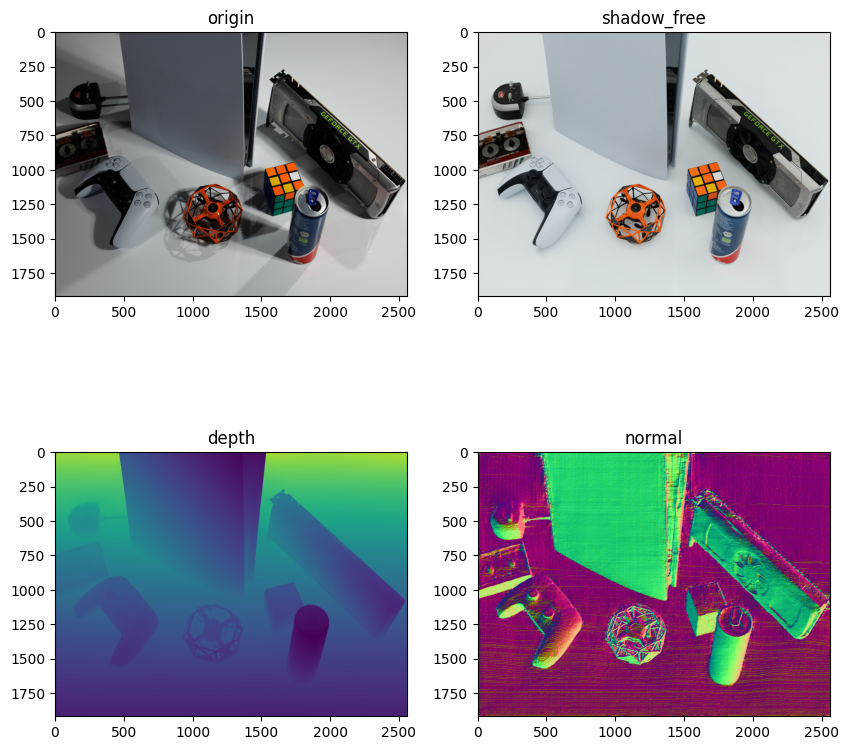

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random


random_idx = random.randint(0, len(list(train_depth_path.glob('*')))-1)



plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('origin')
plt.imshow(Image.open(train_origin_list[random_idx]))

plt.subplot(222)
plt.title('shadow_free')
plt.imshow(Image.open(train_shadow_free_list[random_idx]))

plt.subplot(223)
plt.title('depth')
plt.imshow(np.load(train_depth_list[random_idx]))

plt.subplot(224)
plt.title('normal')
plt.imshow(Image.fromarray(np.load(train_normal_list[random_idx]).transpose(1,2,0)))